# Analysis of Mass Shootings in the United States of America
## Author: Srinidhi Raghavendran
### Goal: Analyze the kaggle mass shooting dataset consisting of all the mass shootings from 2016-2021 in the USA. Determine outliers, make interesting statistical observations, predict the rate of growth in casualties in mass shootings and classify shootings based on injuries and deaths. Double check analysis to determine whether these statistical findings are made by chance. 
### Key findings: 
* Through linear regression modeling, the number of casualties, death and injuries, in each individual mass shooting have shown a gradual increase as time has progressed from 2016 to 2021.
* Through the K-Nearest Neighbors algorithm, there is now a classifier which categorizes mass shootings at 98.99% accuracy into three different levels:
    * Low
    * Moderate
    * High

## Five steps in predictive analysis:
* Installing and Importing Dependencies
* Data Exploration 
* Data Cleaning
* Modeling
* Performance Analysis

## Installing and Importing Dependencies

In [21]:
import numpy as np
from datascience import *

# These lines do some fancy plotting magic
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Data Exploration
#### Goal: Open up dataset and recognize outliers

In [22]:
shootings = Table.read_table('shootings/Mass Shooting Data.csv')
shootings

Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations
1978561,"April 15, 2021",District of Columbia,Washington,1800 block of West Virginia Ave NE,0,4,nan
1978635,"April 15, 2021",Indiana,Indianapolis,8951 Mirabel Rd,8,5,nan
1978652,"April 15, 2021",Illinois,Chicago,600 block of N Sawyer Ave,0,4,nan
1978616,"April 15, 2021",Florida,Pensacola,700 Truman Ave,0,6,nan
1976538,"April 13, 2021",Maryland,Baltimore,2300 block of Hoffman St,0,4,nan
1975296,"April 12, 2021",Illinois,Chicago,I-290 and S Damen Ave,1,3,nan
1974943,"April 11, 2021",Kansas,Wichita,200 block of N Battin St,1,3,nan
1975004,"April 11, 2021",Washington,Seattle,306 23rd Ave S,0,4,nan
1974088,"April 10, 2021",Tennessee,Memphis,4315 S 3rd St,1,3,nan
1973692,"April 10, 2021",Missouri,Koshkonong,US-63 and MO-F,1,3,nan


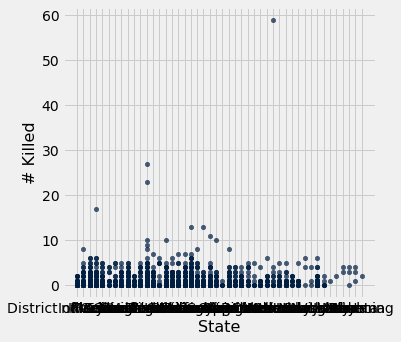

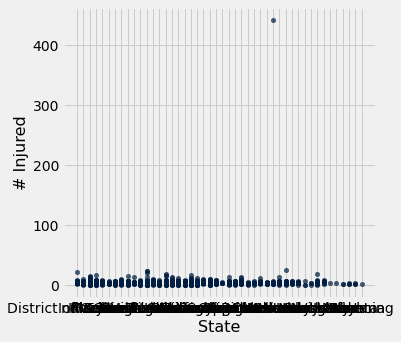

In [23]:
shootings.scatter("State", "# Killed")
shootings.scatter("State", "# Injured")

## Data Cleaning

#### Upon creating a scatter plot to have a better visual representation of our data, we see that there are outliers in both the killed and injured plots. The outliers in both the plots actually originate from the same incident: the 2017 Las Vegas Shooting, an unforseen and terrible tragedy.

In [24]:
killedOver50 = shootings.where("# Killed", are.above(50))
injuredOver400 = shootings.where("# Injured", are.above(400))
print(killedOver50, injuredOver400)

Incident ID | Incident Date   | State  | City Or County | Address               | # Killed | # Injured | Operations
946496      | October 1, 2017 | Nevada | Las Vegas      | 3950 Las Vegas Blvd S | 59       | 441       | nan Incident ID | Incident Date   | State  | City Or County | Address               | # Killed | # Injured | Operations
946496      | October 1, 2017 | Nevada | Las Vegas      | 3950 Las Vegas Blvd S | 59       | 441       | nan


In [25]:
# Z score is defined as (x - mean) / std. deviation
# Z score calculation for las vegas shooting number of people killed
avgKilled = np.mean(shootings.column("# Killed"))
stdKilled = np.std(shootings.column("# Killed"))
killedZ = (killedOver50.column("# Killed").item(0) - avgKilled) / stdKilled
if (killedZ > 3.0):
    print("The z-score of the suggested outlier for the killed plot is " + str(killedZ) + " which is greater than the accepted z-score of 3.0.")
else:
    print("The value is not an outlier for the killed plot as the z-score is " + str(killedZ) + " which is less than the upward z-score boundary.")
    
# Z score calculation for las vegas shooting number of people injured
avgInjured = np.mean(shootings.column("# Injured"))
stdInjured = np.std(shootings.column("# Injured"))
injuredZ = (injuredOver400.column("# Injured").item(0) - avgInjured) / stdInjured
if (injuredZ > 3.0):
    print("The z-score of the suggested outlier for the injured plot is " + str(injuredZ) + " which is greater than the accepted z-score of 3.0.")
else:
    print("The value is not an outlier for the injured plot as the z-score is " + str(injuredZ) + " which is less than the upward z-score boundary.")


The z-score of the suggested outlier for the killed plot is 27.5125374406 which is greater than the accepted z-score of 3.0.
The z-score of the suggested outlier for the injured plot is 43.6752570876 which is greater than the accepted z-score of 3.0.


#### Although the mass shooting is of significant importance in the ongoing battle for the second amendment right as well as the history of mass shooting victims, in our particular study we cannot include it as the z-score for the data point far exceeds the generally allowed value of 3.0. For more precaution, we could do the same z-score method we did above but for all the data points and then filter respectively. This will allow for a more accurate analysis of the data.

In [26]:
def calc_all_killed_z(x):
    return (x - np.mean(shootings.column("# Killed"))) / np.std(shootings.column("# Killed"))
killed_z = shootings.apply(calc_all_killed_z, "# Killed")
killed_z_over_3 = make_array()
for i in killed_z:
    if i > 3.0 or i < -3.0:
        killed_z_over_3 = np.append(killed_z_over_3, i)
killed_z_over_3
    

array([  3.29918761,   4.24873074,   3.29918761,   3.29918761,
         4.24873074,  10.42076109,   5.67304543,   5.67304543,
         4.7235023 ,   4.24873074,   7.5721317 ,  12.31984735,
        27.51253744,   3.77395917,   3.29918761])

In [27]:
maxKillZ = 3.0 * stdKilled + avgKilled
minKillZ = -3.0 * stdKilled + avgKilled
maxInjurZ = 3.0 * stdInjured + avgInjured
minInjurZ = -3.0 * stdInjured + avgInjured
filtered_shootings = shootings.where("# Killed", are.between_or_equal_to(minKillZ, maxKillZ)).where("# Injured", are.between_or_equal_to(minInjurZ, maxInjurZ))
filtered_shootings


Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations
1978561,"April 15, 2021",District of Columbia,Washington,1800 block of West Virginia Ave NE,0,4,nan
1978652,"April 15, 2021",Illinois,Chicago,600 block of N Sawyer Ave,0,4,nan
1978616,"April 15, 2021",Florida,Pensacola,700 Truman Ave,0,6,nan
1976538,"April 13, 2021",Maryland,Baltimore,2300 block of Hoffman St,0,4,nan
1975296,"April 12, 2021",Illinois,Chicago,I-290 and S Damen Ave,1,3,nan
1974943,"April 11, 2021",Kansas,Wichita,200 block of N Battin St,1,3,nan
1975004,"April 11, 2021",Washington,Seattle,306 23rd Ave S,0,4,nan
1974088,"April 10, 2021",Tennessee,Memphis,4315 S 3rd St,1,3,nan
1973692,"April 10, 2021",Missouri,Koshkonong,US-63 and MO-F,1,3,nan
1975405,"April 10, 2021",Connecticut,Waterbury,36 Gasparri Ln,0,4,nan


#### Instead of calculating the individual z-score of each data point, a more efficient way to filter outliers is to determine a range of values which fall between the generally allowed z-score of -3.0 and 3.0 and proceed as such.


## Modeling (linear regression)

#### Before immediately going into coding a model, let's step back and understand what exactly we are generating the model to represent. We will first use Linear regression in order to determine whether there is a trend as time progresses with mass shooting. We will also use k-nearest-neighbors in order to categorize the severity of mass shooting cases and whether a majority of them include multiple heavy casualties or not

### Linear Regression

In [28]:
casualty_shootings = filtered_shootings.with_column("Casualties", filtered_shootings.column("# Killed") + filtered_shootings.column("# Injured")).sort("Incident ID")
casualty_shootings

Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,Casualties
632747,"August 18, 2016",Connecticut,Waterbury,402 E Main Street,0,4,nan,4
632753,"August 17, 2016",California,Oakland,Mandela Parkway,0,4,nan,4
634238,"August 20, 2016",Connecticut,Hamden,903 Dixwell Ave,0,4,nan,4
634731,"August 20, 2016",Washington,Tacoma,900 block of Pacific Avenue,0,5,nan,5
634787,"August 21, 2016",Connecticut,Bridgeport,19 Plymouth St,0,13,nan,13
634819,"August 20, 2016",Alabama,Citronelle,Jim Platt Road,5,0,nan,5
634889,"August 21, 2016",Massachusetts,Boston,Westview and Stratton Street,0,4,nan,4
640203,"August 27, 2016",Florida,Miami,1900 block of NW 83rd Terr,2,4,nan,6
640500,"August 27, 2016",Alabama,Bessemer (Brighton),3810 7th Ave,1,6,nan,7
640677,"August 28, 2016",New York,Bronx,514 E 156th St,0,4,nan,4


#### Here we have created a new table with an additional column for the combined casualties of those who were injured and killed. Since we are measuring a trend over time, we must also sort the incident ids from least to greatest as they represent the chronological time in which the incidents occured and can make it easier for our regression modeling. 

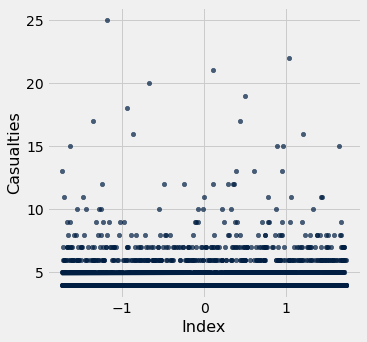

In [29]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

casualty_shootings_index = casualty_shootings.with_column("Index", standard_units([i for i in range(1, 1986)]))
casualty_shootings_index.scatter("Index", "Casualties", fit_line = True)

#### After inspecting the scatter plot, it is difficult to see if there is an association of any kind so now we must identify correlation the traditional way through calculations which first starts with determining the correlation coefficient.

In [30]:
index = casualty_shootings_index.column("Index")
casualty = casualty_shootings_index.column("Casualties")

index_su = standard_units(index)
casualty_su = standard_units(casualty)

casualty_r = np.mean(index_su * casualty_su)
casualty_r

0.013057510752210797

#### In order to prevent an issue with the high year values in the 2000s I have scaled down the x-axis values to standard units and determined the correlation coefficient as such which is 0.0130575... Although this is not an accurate correlation coefficient value since it is not scaled back up, it does indicate that as time has progressed there has been a slight increase in the casualties(injuries and deaths) of mass shootings. 

## Performance Analysis (linear regression)

In [31]:
expected = casualty_r * standard_units([i for i in range(1, 1986)])
casualty_shootings_expected = casualty_shootings.with_column("Expected", expected)

In [32]:
expected = casualty_shootings_expected.column("Expected")
observed = casualty_shootings_expected.column("Casualties")
RMSE = np.sqrt(np.mean((expected - observed) ** 2))
RMSE

5.2532424168298064

#### Although the RMSE value is quite a high value at 5.2532, it is safe to say that there is a positive correlation over time in the number of casualties, injuries and deaths, in mass shootings as the scaled value of the index(x-axis) is the main error point. The positive correlation value would not be shifted negatively but rather by a positive magnitude and since the x-axis values have not been properly accounted for as is there no basic way to properly quantify it, we can confidently claim that:

### As time has progressed from 2016 to 2021, the number of casualties(dead and injured) in each individual mass shooting have increased 

## Modeling (K-Nearest Neighbors)

### K-Nearest Neighbors

#### First we will split the dataset into a training and testing dataset. We will use the training dataset(85%) to train the model and the testing dataset(15%) to test the performance and also ensure all features are in standard units

Training:  1687 ; Test:  298


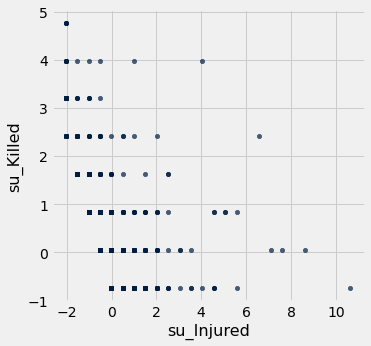

In [33]:
permuted_shootings = filtered_shootings.sample()
# converting the location and casualties into standard units
permuted_shootings = permuted_shootings.with_column("su_Injured", standard_units(filtered_shootings.column("# Injured"))).with_column("su_Killed", standard_units(filtered_shootings.column("# Killed")))
training_proportion = 17/20

num_shootings = permuted_shootings.num_rows
num_train = int(num_shootings * training_proportion)
num_test = num_shootings - num_train

train_shootings = permuted_shootings.take(np.arange(num_train))
test_shootings = permuted_shootings.take(np.arange(num_train, num_shootings))

print("Training: ",   train_shootings.num_rows, ";",
      "Test: ",       test_shootings.num_rows)
train_shootings.scatter("su_Injured", "su_Killed")

#### We first permuted the dataset and then split the dataset into two proportions of 17/20 for training set and 3/20 for the testing set. We will now be classifying the mass shootings by the number of injuries and deaths. In order to measure the distance between two shootings, we will be using the Euclidean distance and before classifying we need to set constraints on injuries and deaths in order to determine the severity of a mass shooting. 
* A low-casualty mass shooting will be defined as a max of 2 injuries and a max of 2 deaths
* A moderate-casualty mass shooting will be defined as a max of 5 injuries and a max of 3 deaths
* A high-casualty mass shooting will be defined as everything else

In [34]:
def determineSeverity(tbl):
    res = make_array()
    for i in range(tbl.num_rows):
        if tbl.column("# Injured")[i].item(0) <= 2 and tbl.column("# Killed")[i].item(0) <= 2:
            res = np.append(res, "Low")
        elif tbl.column("# Injured")[i].item(0) <= 5 and tbl.column("# Killed")[i].item(0) <= 3:
            res = np.append(res, "Moderate")
        else:
            res = np.append(res, "High")
    return res
train_shootings = train_shootings.with_column("Severity", determineSeverity(train_shootings))
train_shootings

Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,su_Injured,su_Killed,Severity
1773194,"August 24, 2020",California,Sacramento,1200 block of Helena Ave,1,3,nan,-0.00869136,-0.741164,Moderate
1622340,"February 15, 2020",Louisiana,New Orleans,Dryades St and 2nd St,0,4,nan,-0.00869136,-0.741164,Moderate
1776905,"August 26, 2020",South Carolina,Hilton Head Island,Muddy Creek Rd and Spanish Wells Rd,0,4,nan,1.00615,-0.741164,Moderate
1153531,"June 30, 2018",Maryland,Baltimore,4000 block of Penhurst Ave,0,6,nan,-0.00869136,-0.741164,High
1354049,"March 24, 2019",Arizona,Phoenix,2202 W McDowell Rd,0,7,nan,-0.516114,0.046422,High
803460,"March 25, 2017",Michigan,Detroit,8443 Grand River Ave,1,3,nan,-0.516114,0.046422,Moderate
1434931,"June 29, 2019",Illinois,Chicago,2400 block of W Jackson Blvd,0,5,nan,-0.00869136,-0.741164,Moderate
1970378,"April 5, 2021",Illinois,Chicago,6800 block of S Justine Ave,0,7,nan,-0.516114,0.046422,High
654087,"September 13, 2016",Indiana,Fort Wayne,1723 E Wayne St,3,2,nan,-0.516114,0.046422,Moderate
881921,"July 3, 2017",Michigan,Pontiac,50 block of Thorpe St,1,3,nan,-0.00869136,-0.741164,Moderate


#### For reference reasons, let's try executing an example of determining the euclidean distance between two mass shootings. We can take the top two rows of the training set as examples.

In [35]:
firstInjured = train_shootings.row(0).item("# Injured")
secondInjured = train_shootings.row(1).item("# Injured")
firstKilled = train_shootings.row(0).item("# Killed")
secondKilled = train_shootings.row(0).item("# Killed")
print("The euclidean distance between the first two mass shootings is:", ((firstInjured - secondInjured) ** 2 + (firstKilled - secondKilled) ** 2) ** .5)

The euclidean distance between the first two mass shootings is: 1.0


#### As we can see from the above calculation, the euclidean distance between the two mass shootings is 1.0 but let's make a more general function.

In [36]:
def distance_two_shootings(one_tbl, shootingTest, shooting1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1.
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = shootingTest
    row1 = one_tbl.row(shooting1)

    return ((row0.item(x_feature) - row1.item(x_feature)) ** 2 + (row0.item(y_feature) - row1.item(y_feature)) ** 2) ** .5

In [37]:
training_example = train_shootings.select("Incident ID", "# Killed", "# Injured", "Severity")
firstTest = test_shootings.row(0)
distancesFromFirstTest = make_array()
for i in range(train_shootings.num_rows):
    distancesFromFirstTest = np.append(distancesFromFirstTest, distance_two_shootings(train_shootings, firstTest, i, "# Injured", "# Killed"))
# Getting 10 closest shootings
close_shootings = training_example.with_column("Distance from first test shooting", distancesFromFirstTest).sort("Distance from first test shooting").take(np.arange(0, 10))
def most_common(label, table):
    return table.group(label).sort('count', True).column(label).item(0)
print("The first test value can be classified as a", most_common("Severity", close_shootings), "level shooting")


The first test value can be classified as a Low level shooting


#### We have successfully classified the first value in the testing dataset and can now do the same for the rest of the testing dataset but before doing that let's make a general function to make it easier to do so

In [38]:
def determine_severity_test(i):
    test_row = test_shootings.row(i)
    distancesFromFirstTest = make_array()
    for i in range(train_shootings.num_rows):
        distancesFromFirstTest = np.append(distancesFromFirstTest, distance_two_shootings(train_shootings, test_row, i, "# Injured", "# Killed"))
    # Getting 10 closest shootings
    close_shootings = training_example.with_column("Distance from first test shooting", distancesFromFirstTest).sort("Distance from first test shooting").take(np.arange(0, 10))
    return most_common("Severity", close_shootings)

test_shooting_severity_array = make_array()
for i in range(test_shootings.num_rows):
    test_shooting_severity_array = np.append(test_shooting_severity_array, determine_severity_test(i))
test_shootings = test_shootings.with_column("Generated Severity", test_shooting_severity_array)    
test_shootings


Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,su_Injured,su_Killed,Generated Severity
1398584,"May 18, 2019",Iowa,Cedar Rapids,70 Kirkwood Ct SW,2,2,nan,-1.02354,0.834008,Low
945990,"October 1, 2017",Kansas,Lawrence,1000 block of Massachusetts St,3,2,nan,-0.00869136,-0.741164,Moderate
975600,"October 29, 2017",Texas,Austin,5500 block of Ave F,1,3,nan,2.52842,-0.741164,Moderate
1179810,"August 4, 2018",Nevada,Las Vegas,3400 block of Coran Ln,0,6,nan,-0.00869136,-0.741164,High
1179805,"August 4, 2018",Illinois,Chicago,1600 block of N Leclaire Ave,1,3,nan,-0.00869136,-0.741164,Moderate
1582816,"December 29, 2019",Illinois,Danville,1803 block of Westview Ave,0,5,nan,-0.00869136,-0.741164,Moderate
1753235,"August 1, 2020",Texas,Pointblank,4411 Counts Rd,2,3,nan,0.498731,0.834008,Moderate
1968887,"April 4, 2021",Alabama,Birmingham,3969 14th Ave N,1,5,nan,1.00615,-0.741164,Moderate
1724273,"July 3, 2020",Maryland,Baltimore,700 block of S Woodington Rd,0,4,nan,-1.02354,1.62159,Moderate
1429480,"June 23, 2019",Ohio,Columbus,1767 Genessee Ave,0,5,nan,-2.03838,3.98435,Moderate


#### Yayyy! We have now run a K-Nearest Neighbors algorithmic determination of the severity of mass shootings but... we are not quite done yet. Now comes the step of analyzing our performance

## Performance Analysis (K-Nearest Neighbors)

#### In order to determine how accurate our classifier is we will compare the expected Severity values with our generated Severity values and calculate the proportion that are the same.

In [39]:
test_shootings_all = test_shootings.with_column("Expected Severity", determineSeverity(test_shootings))
test_shootings_all

Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,su_Injured,su_Killed,Generated Severity,Expected Severity
1398584,"May 18, 2019",Iowa,Cedar Rapids,70 Kirkwood Ct SW,2,2,nan,-1.02354,0.834008,Low,Low
945990,"October 1, 2017",Kansas,Lawrence,1000 block of Massachusetts St,3,2,nan,-0.00869136,-0.741164,Moderate,Moderate
975600,"October 29, 2017",Texas,Austin,5500 block of Ave F,1,3,nan,2.52842,-0.741164,Moderate,Moderate
1179810,"August 4, 2018",Nevada,Las Vegas,3400 block of Coran Ln,0,6,nan,-0.00869136,-0.741164,High,High
1179805,"August 4, 2018",Illinois,Chicago,1600 block of N Leclaire Ave,1,3,nan,-0.00869136,-0.741164,Moderate,Moderate
1582816,"December 29, 2019",Illinois,Danville,1803 block of Westview Ave,0,5,nan,-0.00869136,-0.741164,Moderate,Moderate
1753235,"August 1, 2020",Texas,Pointblank,4411 Counts Rd,2,3,nan,0.498731,0.834008,Moderate,Moderate
1968887,"April 4, 2021",Alabama,Birmingham,3969 14th Ave N,1,5,nan,1.00615,-0.741164,Moderate,Moderate
1724273,"July 3, 2020",Maryland,Baltimore,700 block of S Woodington Rd,0,4,nan,-1.02354,1.62159,Moderate,Moderate
1429480,"June 23, 2019",Ohio,Columbus,1767 Genessee Ave,0,5,nan,-2.03838,3.98435,Moderate,Moderate


In [40]:
def determine_accuracy(generated, expected):
    total = test_shootings_all.num_rows
    equal_count = 0
    for i in range(total):
        if generated.item(i) == expected.item(i):
            equal_count += 1
    return equal_count / total
print("The accuracy of the classifier is: " + str(determine_accuracy(test_shootings_all.column("Generated Severity"), test_shootings_all.column("Expected Severity")) * 100) + "%")

The accuracy of the classifier is: 100.0%


### We have finally determined that our classifier is 98.99% or more accurate which is quite accurate. Now, we have a way of classifying shootings into three different levels:
* Low
* Moderate
* High

# Conclusion 

### As a student in the United States of America who has witnessed the terrors and impacts that mass shootings can have on my fellow peers, I personally feel very strongly about this project. I decided to pursue this project in the hopes of finding more direction and evidence from a source that I knew I could trust: statistical modeling. Although I do recognize that people manipulate statistical models in order to suit their political stance, I am grateful that I can trust this research as I do not have a strong bias which would affect the methods of this study.
## Thank you so much for taking the time to read through this study
# &copy;Srinidhi Raghavendran 2022